In [325]:
import random
import csv
import pickle
import json
import re
import time
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoCV, RidgeCV, Lasso, Ridge
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_val_predict, learning_curve
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, plot_precision_recall_curve
from sklearn.metrics import roc_curve, r2_score, precision_recall_fscore_support, plot_confusion_matrix, plot_roc_curve
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.dummy import DummyClassifier
from scipy.spatial import distance
import imblearn.over_sampling

In [99]:
df = pd.read_pickle('LoL_df.pkl')

In [3]:
df.columns

Index(['Blue Winner', 'Match Length', 'Blue First Blood', 'Blue First Tower',
       'Blue First Inhibitor', 'Blue First Baron', 'Blue First Dragon',
       'Blue First Herald', 'Blue Tower Kills', 'Blue Inhibitor Kills',
       ' Blue Baron Kills', 'Blue Dragon Kills', 'Blue Rift Herald Kills',
       'Red Tower Kills', 'Red Inhibitor Kills', ' Red Baron Kills',
       'Red Dragon Kills', 'Red Rift Herald Kills'],
      dtype='object')

In [285]:
mask = (df['Blue Winner'] == 1) & (df['Blue First Tower'] == 1)

In [289]:
df[mask]['Blue First Blood'].value_counts()

1    22730
0    11901
Name: Blue First Blood, dtype: int64

In [263]:
y = df['Blue Winner']
X = df[['Blue First Blood', 'Blue First Dragon' ,'Blue First Tower']] #'Blue First Herald', 'Blue First Tower'

In [264]:
X_train_total, X_test, y_train_total, y_test = train_test_split(X, y, test_size = 0.2, random_state = 8675309)
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=0.25, random_state=407)

In [265]:
std = StandardScaler(with_mean = False)
stdtest = StandardScaler(with_mean = False)
stdtotal= StandardScaler(with_mean= False)

In [266]:
X_train_total_scale = stdtotal.fit_transform(X_train_total)
X_train_scale = std.fit_transform(X_train)
X_val_scale = std.transform(X_val)
X_test_scale = stdtest.fit_transform(X_test)

In [267]:
#sns.pairplot(df)

In [ ]:
#def rmse(actuals, preds):
 #   return np.sqrt(((actuals - preds) ** 2).mean())

In [156]:
rf = RandomForestClassifier(n_estimators = 100, n_jobs=-1)

In [107]:
#rf.fit(X_train_total_scale,y_train_total)

RandomForestClassifier(n_jobs=-1)

In [164]:
scores = cross_val_score(rf, X_train_total_scale, y_train_total, cv=10, scoring = 'f1')

In [165]:
scores

array([0.7413496 , 0.7376074 , 0.74145952, 0.73828692, 0.73081511,
       0.73623188, 0.7342241 , 0.73352894, 0.72763419, 0.73919404])

In [268]:
logreg = LogisticRegression(solver='lbfgs', C=1)

In [269]:
logreg.fit(X_train_total_scale, y_train_total)

LogisticRegression(C=1)

In [270]:
scores = cross_val_score(logreg, X_train_total_scale, y_train_total, cv=10, scoring = 'f1')

In [271]:
scores

array([0.7413496 , 0.7376074 , 0.74145952, 0.73828692, 0.73081511,
       0.73623188, 0.7342241 , 0.73352894, 0.72763419, 0.73919404])

In [272]:
preds = logreg.predict(X_val_scale)

In [273]:
confusion_matrix(y_val, preds)

array([[6674, 2786],
       [2243, 6827]])

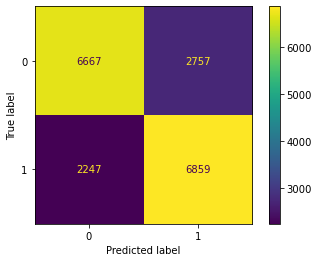

In [322]:
plot_confusion_matrix(logreg, X_test_scale,y_test)

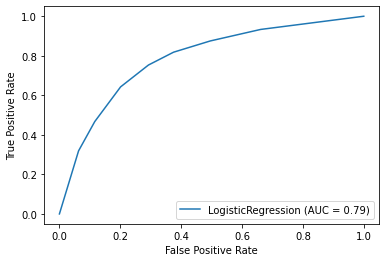

In [323]:
plot_roc_curve(logreg, X_test_scale, y_test)
plt.show()                                 

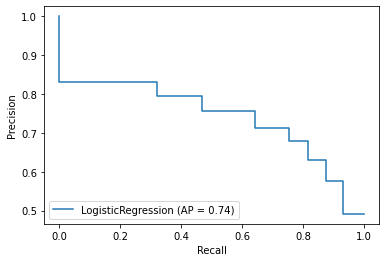

In [326]:
plot_precision_recall_curve(logreg, X_test_scale, y_test)

In [275]:
logreg.predict_proba(X_test_scale)

array([[0.69199435, 0.30800565],
       [0.83395189, 0.16604811],
       [0.32787514, 0.67212486],
       ...,
       [0.75168149, 0.24831851],
       [0.44731788, 0.55268212],
       [0.17913048, 0.82086952]])

In [276]:
pred_scores

array([0, 0, 1, ..., 0, 1, 1])

In [327]:
np.exp(logreg.coef_)

array([[1.28805995, 1.49232926, 2.48942218]])

In [328]:
logreg.coef_

array([[0.25313717, 0.40033816, 0.91205063]])

In [297]:
gbm = xgb.XGBClassifier( 
                       n_estimators=30000, #arbitrary large number
                       max_depth=3,
                       objective="binary:logistic",
                       learning_rate=.1, 
                       subsample=1,
                       min_child_weight=1,
                       colsample_bytree=.8
                      )

In [307]:
eval_set=[(X_train_scale,y_train),(X_val_scale,y_val)]

In [308]:
boosted_model = gbm.fit( 
                    X_train_scale, y_train,
                    eval_set=eval_set,
                    eval_metric='error',
                    early_stopping_rounds=20,
                    verbose=True #gives output log as below
                   )

XGBoostError: [16:50:37] /Users/runner/miniforge3/conda-bld/xgboost_1593723618214/work/src/data/data.cc:373: Check failed: labels_.Size() == num_row_ (66708 vs. 55589) : Size of labels must equal to number of rows.
Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x0000001a1a25061e dmlc::LogMessageFatal::~LogMessageFatal() + 110
  [bt] (1) 2   libxgboost.dylib                    0x0000001a1a295999 xgboost::MetaInfo::Validate(int) const + 1193
  [bt] (2) 3   libxgboost.dylib                    0x0000001a1a3005e6 xgboost::LearnerImpl::ValidateDMatrix(xgboost::DMatrix*) const + 54
  [bt] (3) 4   libxgboost.dylib                    0x0000001a1a2ef8dc xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 268
  [bt] (4) 5   libxgboost.dylib                    0x0000001a1a248bea XGBoosterUpdateOneIter + 154
  [bt] (5) 6   libffi.6.dylib                      0x0000000108bb1884 ffi_call_unix64 + 76
  [bt] (6) 7   ???                                 0x00007ffee7bd1730 0x0 + 140732786349872



In [37]:
'''preds = model.predict(D_test)
best_preds = np.asarray([np.argmax(line) for line in preds])

print("Precision = {}".format(precision_score(Y_test, best_preds, average='macro')))
print("Recall = {}".format(recall_score(Y_test, best_preds, average='macro')))
print("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))'''

'preds = model.predict(D_test)\nbest_preds = np.asarray([np.argmax(line) for line in preds])\n\nprint("Precision = {}".format(precision_score(Y_test, best_preds, average=\'macro\')))\nprint("Recall = {}".format(recall_score(Y_test, best_preds, average=\'macro\')))\nprint("Accuracy = {}".format(accuracy_score(Y_test, best_preds)))'

In [ ]:
scores = cross_val_score(boosted_model, X_train_scale, y_train, cv=3, scoring = 'f1')

In [177]:
scores

array([0.7413496 , 0.7376074 , 0.74145952, 0.73828692, 0.73081511,
       0.73623188, 0.7342241 , 0.73352894, 0.72763419, 0.73919404])

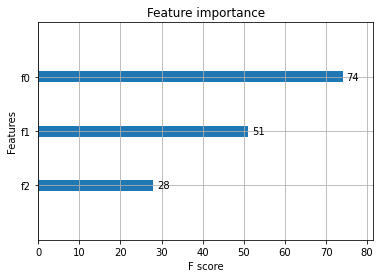

In [317]:
xgb.plot_importance(gbm, importance_type = 'weight')

In [309]:
#X_train_total_scale = stdtotal.fit_transform(X_train_total)
kf = KFold(n_splits=10)
for train_index, val_index in kf.split(X_train_total_scale):
    X_train, X_val = X_train_total_scale[train_index], X_train_total_scale[val_index]
    y_train, y_val = y_train_total.values[train_index], y_train_total.values[val_index]
    gbm = xgb.XGBClassifier(n_estimators=30000,
                            max_depth=4,
                            objective='binary:logistic',
                            learning_rate=.05,
                            subsample=.8,
                            min_child_weight=3,
                            colsample_bytree=.8)
    eval_set=[(X_train,y_train),(X_val,y_val)]
    gbm.fit(X_train_total_scale,y_train_total,eval_set=eval_set,eval_metric='error',early_stopping_rounds=50,verbose=False)
    print(f1_score(y_val, gbm.predict(X_val, ntree_limit=gbm.best_ntree_limit)))

0.7419056429232191
0.7328675087342111
0.7448094612352167
0.7352157698454981
0.732237539766702
0.7367730077458317
0.7348124669836239
0.733386709367494
0.7267426451099922
0.7414066631411951


First Blood, First Dragon, First Herald,
First Tower, First Baron, First Inhibitor